# Analysis of output files
## Prepare environment, functions etc.

In [1]:
import os
import sys
import pandas
import matplotlib
import numpy
from algorithm_tester.helpers import FilePair

# Zapnout zobrazování grafů (procento uvozuje „magickou” zkratku IPythonu):
%matplotlib inline

path = 'tester_results'
solutions = '../data'

In [2]:
#pandas.set_option('display.max_rows', None)
#pandas.read_csv?

## Important functions

In [3]:
def get_file_paths_from_dir(path: str, include_sol: bool = False, include_instance: bool = True) -> (str, str):
    dataset_prefix: str = path.split("/")[-1]
    for root, _, files in os.walk(path):
        dataset: str = dataset_prefix + "_" + "_".join(root.replace(path, "")[1:].split('/'))
        for file in files:
            if "column" not in file:
                if ("_sol" in file and include_sol) or ("_inst" in file and include_instance):
                    yield (dataset, f'{root}/{file}')

def get_cols_list(path: str):
    cols = pandas.read_csv(path, index_col=None, delimiter=" ", header=None)
    return list(cols.iloc[0])

def load_sol_from_dir(folder_path: str, column_list):
    """ Load solutions from directory files into table. """
    it = get_file_paths_from_dir(folder_path, include_sol=True, include_instance=False)
    output_table = None
        
    for (dataset, filepath) in it:
        curr_table = pandas.read_csv(filepath, index_col=None, delimiter=" ", header=None).iloc[:,0:3]
        curr_table.columns = column_list
        curr_table["dataset"] = dataset
                
        if output_table is not None:
            output_table = output_table.append(curr_table, ignore_index=True)
        else:
            output_table = curr_table
    
    return output_table

def load_data_from_dir(folder_path: str, column_list):
    """ Load data from directory files into table. """
    it = get_file_paths_from_dir(folder_path)
    output_table = None
    
    for (dataset, filepath) in it:
        curr_table = pandas.read_csv(filepath, index_col=None, delimiter=" ", header=None)
        curr_table.columns = column_list
        curr_table["dataset"] = dataset
                
        if output_table is not None:
            output_table = output_table.append(curr_table, ignore_index=True)
        else:
            output_table = curr_table
    
    #output_table = output_table.set_index(['algorithm', 'dataset', 'id', "item_count"])
    #output_table.sort_values(by=["algorithm", "dataset", "item_count", "id"], inplace=True)
    return output_table

def construct_table_from(filePair: FilePair):
    solution_table = pandas.read_csv(filePair.solutionFile, header=None, index_col=None, delimiter=" ")
    data_table = pandas.read_csv(filePair.dataFile, header=None, index_col=None, delimiter=" ")
    
    item_count = data_table.iloc[0, 1]
    
    solution_table = solution_table.drop_duplicates(subset=[0], keep='first').reset_index()

    data_table = data_table.iloc[:, 4:]
    data_table = data_table[data_table.columns[::2]]

    info_table = pandas.concat([solution_table.iloc[:, 1], solution_table.iloc[:, 3], data_table.max(axis=1)], axis=1)
    info_table.columns = ["id", "best_value", "max_cost"]
    info_table["item_count"] = item_count
    return info_table

def create_avg_time_table(table, name: str, column_name: str = "item_count"):
    # Create a table of average times according to algorithm and item_count columns
    avg_times = table.groupby(["algorithm_name", column_name])['elapsed_time'] \
        .mean().reset_index().set_index(["algorithm_name", column_name])
    avg_times = avg_times.round(2)

    # Move all values of algorithm column into separate columns
    avg_times = avg_times.unstack("algorithm_name")
    avg_times.columns = avg_times.columns.droplevel()
    avg_times.name = f"Avg #configs per {column_name}"
    avg_times.sort_values(by=column_name, inplace=True)
    #avg_times.fillna("-", inplace=True)

    # Save the dataframe to csv
    #avg_times.to_excel(f'excel/{name}_avg_times.xlsx', sheet_name=name)
    
    return avg_times

def create_avg_error_table(table, column_name: str):
    table["relative_error"] = numpy.abs(table["best_value"] - table["found_value"])/table["best_value"]
    table = table.fillna(0)
    
    error_group = table.groupby([column_name, "algorithm_name"])["relative_error"]

    error_max = error_group.max().reset_index() \
        .rename(columns={'relative_error':'max_relative_error'})
    error_avg = error_group.mean().reset_index() \
        .rename(columns={'relative_error':'avg_relative_error'})
    
    # Construct, unstack
    avg_error = pandas.merge(error_max, error_avg, on=[column_name, "algorithm_name"])
    #avg_error = error_max.join(error_avg).round(6)
    #avg_error.columns = ["max_relative_error", "avg_relative_error"]
    avg_error.name = f"Avg & max relative error per "

    #avg_error.to_excel(f"excel/{name}_avg_error.xlsx", sheet_name=name)
    
    return avg_error

In [4]:
# Create column lists

sol_cols = ["id", "item_count", "best_value"]
cols = get_cols_list(f'{path}/column_description.dat')

## Put data from all analysis files into tables

In [5]:
# Load tables of all strategies
#balance_table = load_data_from_dir(f'{path}/Balance', cols) \
#    .rename(columns={'instance_info':'balance'})
#robust_table = load_data_from_dir(f'{path}/Robust', cols) \
#    .drop(columns="instance_info")

nk_table = load_data_from_dir(f'{path}/NK', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/NK', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
zkc_table = load_data_from_dir(f'{path}/ZKC', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/ZKC', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
zkw_table = load_data_from_dir(f'{path}/ZKW', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/ZKW', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
nk_table

create_avg_error_table(nk_table, "item_count")

,item_count,algorithm_name,max_relative_error,avg_relative_error
0,30,SA,0.121016,0.007754
1,30,SAPenalty,0.634846,0.392762
2,30,SA_OLD,0.160981,0.038901
3,32,SA,0.110054,0.009622
4,32,SAPenalty,0.767103,0.393080
5,32,SA_OLD,0.163892,0.046557
6,35,SA,0.131954,0.011217
7,35,SAPenalty,0.564280,0.396743
8,35,SA_OLD,0.169858,0.054363
9,37,SA,0.141075,0.010340


# Parameter analysis

In [6]:
param_sols = load_sol_from_dir(f'{solutions}/ParamAnalysis', sol_cols) \
    .drop(columns="dataset")

init_temp_table = load_data_from_dir(f'{path}/ParamAnalysis/InitTemperature', cols) \
    .drop(columns=["things", "cycles", "min_temperature", "cooling"]) \
    .merge(param_sols, on=["id", "item_count"])
init_temp_table["init_temp"] = init_temp_table["dataset"]\
    .str.split("_", n = 1, expand = True)[1].astype(int)

cooling_table = load_data_from_dir(f'{path}/ParamAnalysis/Cooling', cols) \
    .drop(columns=["things", "cycles", "min_temperature", "init_temperature"]) \
    .merge(param_sols, on=["id", "item_count"])
cooling_table["cooling_coef"] = cooling_table["dataset"]\
    .str.split("_", n = 1, expand = True)[1].astype(int)

cycles_table = load_data_from_dir(f'{path}/ParamAnalysis/Cycles', cols) \
    .drop(columns=["things", "init_temperature", "min_temperature", "cooling"]) \
    .merge(param_sols, on=["id", "item_count"])
cycles_table["cycles"] = cycles_table["dataset"]\
    .str.split("_", n = 1, expand = True)[1].astype(int)

cycles_table


,id,item_count,algorithm_name,cycles,found_value,elapsed_configs,elapsed_time,dataset,best_value
0,1,32,SA,50,32941,62000,45.145702,Cycles_50,32944
1,1,32,SA_OLD,50,30302,62000,312.735064,Cycles_50,32944
2,1,32,SAPenalty,50,19511,62000,362.063035,Cycles_50,32944
3,1,32,SA,150,32941,186000,149.657889,Cycles_150,32944
4,1,32,SA_OLD,150,31683,186000,942.291557,Cycles_150,32944
...,...,...,...,...,...,...,...,...,...
18130,500,35,SA,100,29457,124000,97.378758,Cycles_100,29684
18131,500,35,SA_OLD,100,29339,124000,668.665596,Cycles_100,29684
18132,500,35,SAPenalty,200,14421,248000,1429.187039,Cycles_200,29684
18133,500,35,SA,200,29457,248000,220.829198,Cycles_200,29684


In [7]:
error_init_temp = create_avg_error_table(init_temp_table, "init_temp")
error_cooling = create_avg_error_table(cooling_table, "cooling_coef")
error_cycles = create_avg_error_table(cycles_table, "cycles")

time_init_temp = create_avg_time_table(init_temp_table, name="initial temperature", column_name="init_temp")
time_cooling = create_avg_time_table(cooling_table, name="cooling coefficient", column_name="cooling_coef")
time_cycles = create_avg_time_table(cycles_table, name="number of cycles", column_name="cycles")


In [8]:
error_init_temp.query('algorithm_name == "SAPenalty" or algorithm_name == "SA"')\
    .set_index(["init_temp", "algorithm_name"]).unstack("algorithm_name")


max_relative_error           avg_relative_error          
algorithm_name                 SA SAPenalty                 SA SAPenalty
init_temp                                                               
100                      0.598615  0.767103           0.017867  0.429180
300                      0.598615  0.767103           0.012245  0.428923
500                      0.598615  0.767103           0.011739  0.429593
700                      0.262642  0.835176           0.009464  0.431327
900                      0.262642  0.835176           0.009193  0.433029
1000                     0.238636  0.835176           0.008800  0.433757
2500                     0.262642  0.909091           0.009483  0.438468

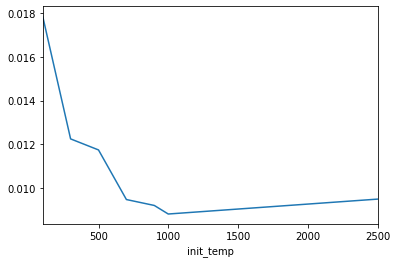

In [9]:
error_init_temp.query('algorithm_name == "SA"').set_index("init_temp").loc[:, "avg_relative_error"].plot()

## DataAnalysis

In [10]:
def getdsol(path: str):
    sol = load_sol_from_dir(path, sol_cols)
    sol["instance_info"] = sol["dataset"].str.split("_", n = 1, expand = True)[1]
    
    return sol

dpath = f'{path}/DataAnalysis'
dsolutions = f'{solutions}/DataAnalysis'

balance_table = load_data_from_dir(f'{dpath}/Balance', cols) \
    .merge(getdsol(f'{dsolutions}/Balance').drop(columns="dataset"), on=["id", "item_count"])\
    .rename(columns={'instance_info':'balance'})
correlation_table = load_data_from_dir(f'{dpath}/Correlation', cols) \
    .merge(getdsol(f'{dsolutions}/Correlation').drop(columns="dataset"), on=["id", "item_count"])\
    .rename(columns={'instance_info':'correlation'})
granularity_heavy_table = load_data_from_dir(f'{dpath}/GranularityHeavy', cols) \
    .merge(getdsol(f'{dsolutions}/GranularityHeavy').drop(columns="dataset"), on=["id", "item_count"])\
    .rename(columns={'instance_info':'constant'})
granularity_light_table = load_data_from_dir(f'{dpath}/GranularityLight', cols) \
    .merge(getdsol(f'{dsolutions}/GranularityLight').drop(columns="dataset"), on=["id", "item_count"])\
    .rename(columns={'instance_info':'constant'})
maxcost_table = load_data_from_dir(f'{dpath}/MaxCost', cols) \
    .merge(getdsol(f'{dsolutions}/MaxCost').drop(columns="dataset"), on=["id", "item_count"])\
    .rename(columns={'instance_info':'maxcost'})
maxweight_table = load_data_from_dir(f'{dpath}/MaxWeight', cols) \
    .merge(getdsol(f'{dsolutions}/MaxWeight').drop(columns="dataset"), on=["id", "item_count"])\
    .rename(columns={'instance_info':'maxweight'})
things_table = load_data_from_dir(f'{dpath}/Things', cols)
weight_cap_ratio_table = load_data_from_dir(f'{dpath}/WeightCapRation', cols) \
    .merge(getdsol(f'{dsolutions}/WeightCapRation').drop(columns="dataset"), on=["id", "item_count"])\
    .rename(columns={'instance_info':'ratio'})

In [11]:
#create_avg_error_table(, "maxcost")

create_avg_error_table(balance_table, "balance")

,balance,algorithm_name,max_relative_error,avg_relative_error
0,Bal,SA,0.697744,0.105258
1,Bal,SA_OLD,0.697744,0.105474
2,Heavy,SA,0.973270,0.061358
3,Heavy,SA_OLD,0.973270,0.060999
4,Light,SA,0.962471,0.061646
5,Light,SA_OLD,0.962471,0.061670


In [12]:
create_avg_error_table(correlation_table, "correlation")

,correlation,algorithm_name,max_relative_error,avg_relative_error
0,Corr,SA,0.587344,0.121438
1,Corr,SA_OLD,0.587344,0.122007
2,Strong,SA,0.570713,0.116916
3,Strong,SA_OLD,0.570713,0.109434
4,Uni,SA,0.540541,0.107474
5,Uni,SA_OLD,0.555856,0.104419


In [13]:
create_avg_error_table(granularity_heavy_table, "constant")

,constant,algorithm_name,max_relative_error,avg_relative_error
0,"0,25",SA,0.978109,0.153921
1,"0,25",SA_OLD,0.978109,0.154390
2,"0,5",SA,1.627620,0.155932
3,"0,5",SA_OLD,1.627620,0.156318
4,"0,75",SA,1.140059,0.151166
5,"0,75",SA_OLD,1.140059,0.151477
6,"1,0",SA,0.853994,0.155855
7,"1,0",SA_OLD,0.854913,0.156009
8,"1,25",SA,0.884749,0.148139
9,"1,25",SA_OLD,0.884749,0.148349


In [14]:
create_avg_error_table(granularity_light_table, "constant")

,constant,algorithm_name,max_relative_error,avg_relative_error
0,"0,25",SA,0.955274,0.153536
1,"0,25",SA_OLD,0.955274,0.153736
2,"0,5",SA,1.699495,0.153336
3,"0,5",SA_OLD,1.699495,0.153645
4,"0,75",SA,1.155070,0.148217
5,"0,75",SA_OLD,1.088469,0.148343
6,"1,0",SA,0.947706,0.153381
7,"1,0",SA_OLD,0.947706,0.153390
8,"1,25",SA,0.907072,0.144027
9,"1,25",SA_OLD,0.880757,0.144011


In [15]:
create_avg_error_table(maxcost_table, "maxcost")

,maxcost,algorithm_name,max_relative_error,avg_relative_error
0,100,SA,3.983376,1.976758
1,100,SA_OLD,3.983376,1.977384
2,200,SA,1.498969,0.694991
3,200,SA_OLD,1.498969,0.695633
4,300,SA,0.673948,0.398343
5,300,SA_OLD,0.684211,0.398758
6,400,SA,0.755291,0.349708
7,400,SA_OLD,0.763030,0.349849
8,500,SA,0.804151,0.400493
9,500,SA_OLD,0.810314,0.400566


In [16]:
create_avg_error_table(maxweight_table, "maxweight")

,maxweight,algorithm_name,max_relative_error,avg_relative_error
0,100,SA,0.025727,0.002139
1,100,SA_OLD,0.054315,0.002489
2,200,SA,0.025727,0.002044
3,200,SA_OLD,0.054315,0.002415
4,300,SA,0.025727,0.002072
5,300,SA_OLD,0.054315,0.002428
6,400,SA,0.025727,0.002107
7,400,SA_OLD,0.054315,0.002463
8,500,SA,0.025727,0.002101
9,500,SA_OLD,0.054315,0.002456


In [29]:
create_avg_error_table(weight_cap_ratio_table, "ratio")

weight_cap_ratio_table.query("algorithm_name == 'SA_OLD'").query("id == 1 and ratio == '0,1'")

,id,item_count,algorithm_name,init_temperature,cooling,min_temperature,cycles,found_value,elapsed_configs,elapsed_time,things,dataset,best_value,ratio,relative_error
4,1,15,SA_OLD,2500.0,0.99,1.0,50,2184,38950,192.386278,11111111111111,WeightCapRation_,701,"0,1",2.115549
64,1,15,SA_OLD,2500.0,0.99,1.0,50,977,38950,312.178623,101000101100010,WeightCapRation_,701,"0,1",0.393723
74,1,15,SA_OLD,2500.0,0.99,1.0,50,1223,38950,303.701255,101110101101000,WeightCapRation_,701,"0,1",0.744650
84,1,15,SA_OLD,2500.0,0.99,1.0,50,701,38950,361.266908,101000100100000,WeightCapRation_,701,"0,1",0.000000
104,1,15,SA_OLD,2500.0,0.99,1.0,50,1886,38950,207.683615,111000101111111,WeightCapRation_,701,"0,1",1.690442
124,1,15,SA_OLD,2500.0,0.99,1.0,50,1783,38950,221.682377,111010101101111,WeightCapRation_,701,"0,1",1.543509
134,1,15,SA_OLD,2500.0,0.99,1.0,50,1657,38950,234.024096,111100101101110,WeightCapRation_,701,"0,1",1.363766
144,1,15,SA_OLD,2500.0,0.99,1.0,50,1443,38950,239.304510,111000101101100,WeightCapRation_,701,"0,1",1.058488
154,1,15,SA_OLD,2500.0,0.99,1.0,50,2176,38950,194.817411,111110111111111,WeightCapRation_,701,"0,1",2.104137
164,1,15,SA_OLD,2500.0,0.99,1.0,50,2043,38950,233.763274,111110101111111,WeightCapRation_,701,"0,1",1.914408


In [37]:
tmp = "/Users/petr/Documents/Projects/Python/AlgorithmTester/analysis/tester_results/DataAnalysis/WeightCapRation"

test = pandas.read_csv(f"{tmp}/WeightCapRation_0,1_inst_SA_OLD_sol.dat", index_col=None, delimiter=" ", header=None)
test.columns = cols
test = test.drop(columns=["init_temperature", "cooling", "min_temperature", "cycles", "elapsed_configs", "elapsed_time", "things"])
print(test)

test = test.merge(getdsol(f'{dsolutions}/WeightCapRation').drop(columns="dataset"), on=["id", "item_count"])

test

     id  item_count algorithm_name  found_value
0     1          15         SA_OLD          701
1     2          15         SA_OLD          652
2     3          15         SA_OLD          862
3     4          15         SA_OLD          606
4     5          15         SA_OLD          735
..  ...         ...            ...          ...
95   96          15         SA_OLD          508
96   97          15         SA_OLD          476
97   98          15         SA_OLD          655
98   99          15         SA_OLD          659
99  100          15         SA_OLD          775

[100 rows x 4 columns]


,id,item_count,algorithm_name,found_value,best_value,instance_info
0,1,15,SA_OLD,701,1886,"0,7"
1,1,15,SA_OLD,701,2176,"0,9"
2,1,15,SA_OLD,701,2043,"0,8"
3,1,15,SA_OLD,701,1783,"0,6"
4,1,15,SA_OLD,701,701,"0,1"
...,...,...,...,...,...,...
995,100,15,SA_OLD,775,1261,"0,4"
996,100,15,SA_OLD,775,1158,"0,3"
997,100,15,SA_OLD,775,1015,"0,2"
998,100,15,SA_OLD,775,1348,"0,5"


In [ ]:
def load_data_from_dir(folder_path: str, column_list):
    """ Load data from directory files into table. """
    it = get_file_paths_from_dir(folder_path)
    output_table = None
    
    for (dataset, filepath) in it:
        curr_table = pandas.read_csv(filepath, index_col=None, delimiter=" ", header=None)
        curr_table.columns = column_list
        curr_table["dataset"] = dataset
                
        if output_table is not None:
            output_table = output_table.append(curr_table, ignore_index=True)
        else:
            output_table = curr_table
    
    #output_table = output_table.set_index(['algorithm', 'dataset', 'id', "item_count"])
    #output_table.sort_values(by=["algorithm", "dataset", "item_count", "id"], inplace=True)
    return output_table

